In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
from lutils import *

np.random.seed(1)

# 定价，分位Hot (Infrequent Access Tier)、Cold (Glacier Instant Retrieval)和Glacier (Glacier Flexible Retrieval )。US-East (Ohio)
S_h = 0.02
S_c = 0.004
S_g = 0.0036
G_h = 0.001 # per 1000
G_c = 0.01  # per 1000
G_g = 0.0004  # per 1000
R_h = 0.01
R_c = 0.03
R_g = 0.013

# Hot、Cold和Glacier的模拟延迟
L_h = 0.5
L_c = L_h * 10
L_g = L_c * 5

In [ ]:
test_v = None
test_s = None
with open('../data/media7m', 'r', encoding='utf8') as f:
    d = json.loads(f.readline())
    test_v = d['visits']
    test_s = d['size'] 

### 开始试验

In [2]:

def cal_q(pre_q, latency, L_M):
    return max([pre_q + latency - L_M, 0])

def cal_cost(tier, pre_tier, visit, size):
    c = 0
    if tier == 0: # in the hot tier
        c += S_h + R_h * visit * size + G_h * visit
    elif tier == 1: # in the cold tier
        c += S_c + R_c * visit * size + G_c * visit
    elif tier == 2: # in the glacier tier
        c += S_g + R_g * visit * size + G_g * visit
    
    if tier != pre_tier:
        # tier migration cost
        if pre_tier == 0:
            c += 0.01
        elif pre_tier == 1:
            c += 0.02
        elif pre_tier == 2:
            c += 0.03
    return c
    
def gen_latency(tier):
    base_var = 0.1
    if tier == 0: # in the hot tier
        return np.random.normal(L_h, base_var)
    elif tier == 1: # in the cold tier
        return np.random.normal(L_c, L_c/L_h * base_var)
    elif tier == 2: # in the glacier tier
        return np.random.normal(L_g, L_g/L_h * base_var - 1.5)
    
def drift_plus_penalty(q, latency, cost, L_M, V):        
    return q * (latency - L_M) + V * cost

def argmin_drift_plus_penalty(q, visit, size, L_M, V):
    dps = []
    costs = [
            cal_cost(0, visit, size),
            cal_cost(1, visit, size),
            cal_cost(2, visit, size)]
    latencies = [
            gen_latency(0),
            gen_latency(1),
            gen_latency(2)]
    dps.append(drift_plus_penalty(q, latencies[0], costs[0], L_M, V))
    dps.append(drift_plus_penalty(q, latencies[1], costs[1], L_M, V))
    dps.append(drift_plus_penalty(q, latencies[2], costs[2], L_M, V))
    
    min_tier = np.argmin(dps) # 0为hot，1为cold，2为glacier
    return costs[min_tier], latencies[min_tier], min_tier
    
def alg(visits, size, L_M=1, V=10000):
    q = 0
    qs = [q]
    cs = []
    ls = []
    ts = []
    for v in visits:
        # 对当前时刻的v，求使得加罚函数值最小的存储层导致的成本和延迟
        cost, latency, tier = argmin_drift_plus_penalty(q, v, size, L_M, V)
        q = cal_q(q, latency, L_M)
        qs.append(q)
        cs.append(cost)
        ls.append(latency)
        ts.append(tier)
    return qs, cs, ls, ts

实验组成


In [4]:
from lutils import plot_line

Vs = [1200, 2400, 3600]
q_multi = []
for i in Vs:
    qs, cs, ls, ts = alg(test_v, test_s, V=i)
    q_multi.append([np.arange(len(qs)), qs])


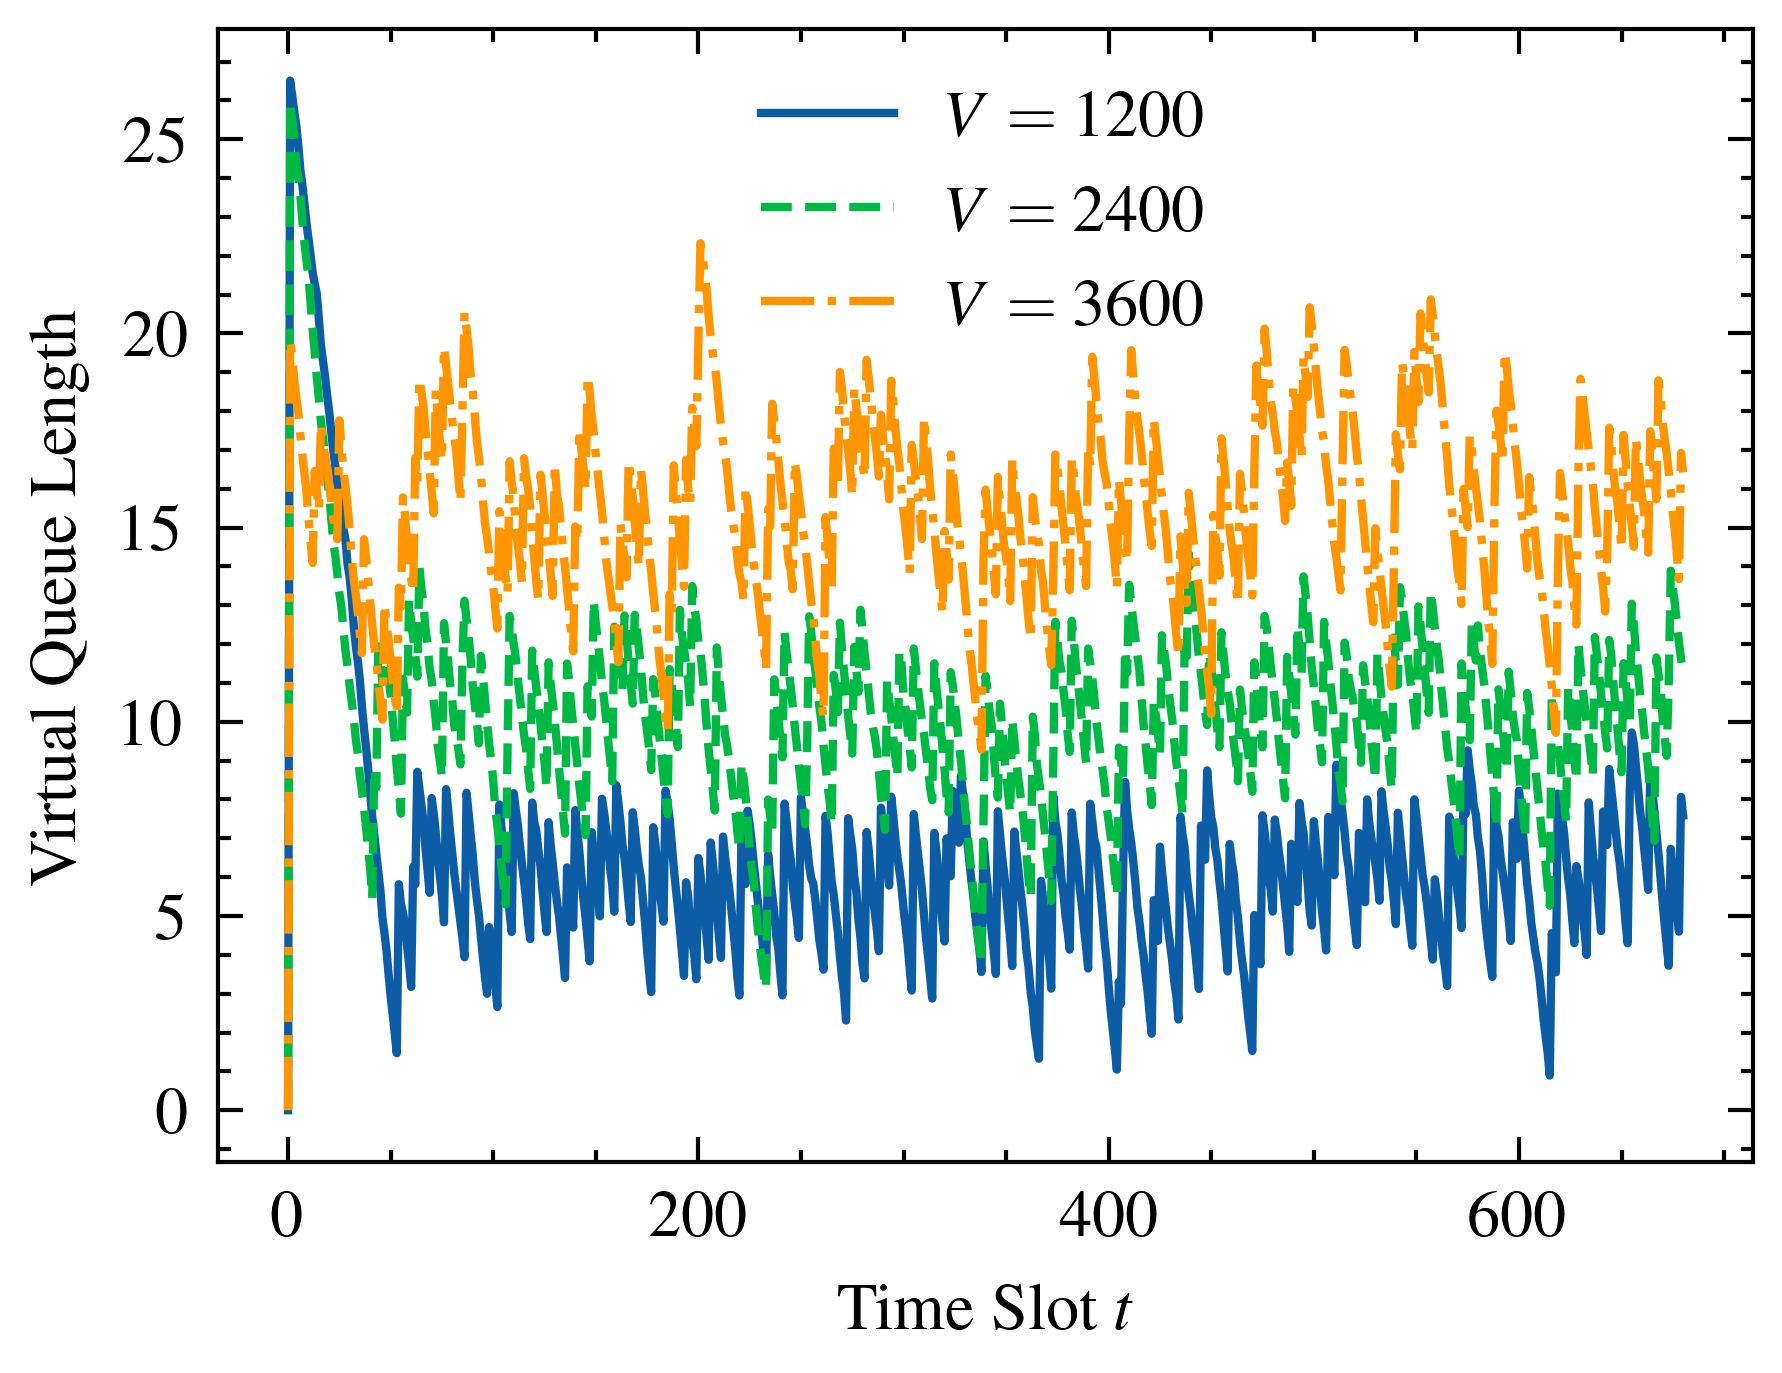

In [81]:
plot_line(q_multi, [f'$V={Vs[0]}$', f'$V={Vs[1]}$', f'$V={Vs[2]}$'], 'Time Slot $t$', 'Virtual Queue Length', './V_queuelen.pdf') 

In [7]:
from lutils import plot_h

Vs2 = [1200, 2400, 3600]
t_multi2 = []
c_multi2 = []
for i in Vs2:
    qs, cs, ls, ts = alg(test_v, test_s, V=i, L_M=3)
    t_multi2.append(ts)
    c_multi2.append(cs)


opt_tiers = []
opt_cost = 0
for v in test_v:
    tmp_costs = [cal_cost(0, -1, v, test_s), cal_cost(1, -1, v, test_s), cal_cost(2, -1, v, test_s)]
    opt_cost += np.min(tmp_costs)
    opt_tiers.append(np.argmin(tmp_costs))


In [ ]:
sum_c = np.sum(c_multi2, axis=1)
dis_c = sum_c - opt_cost
plot_h(dis_c/dis_c[0], [f'$V={Vs2[0]}$', f'$V={Vs2[1]}$', f'$V={Vs2[2]}$'], 'Distance from Optimal Cost', './V_costdistance.pdf')

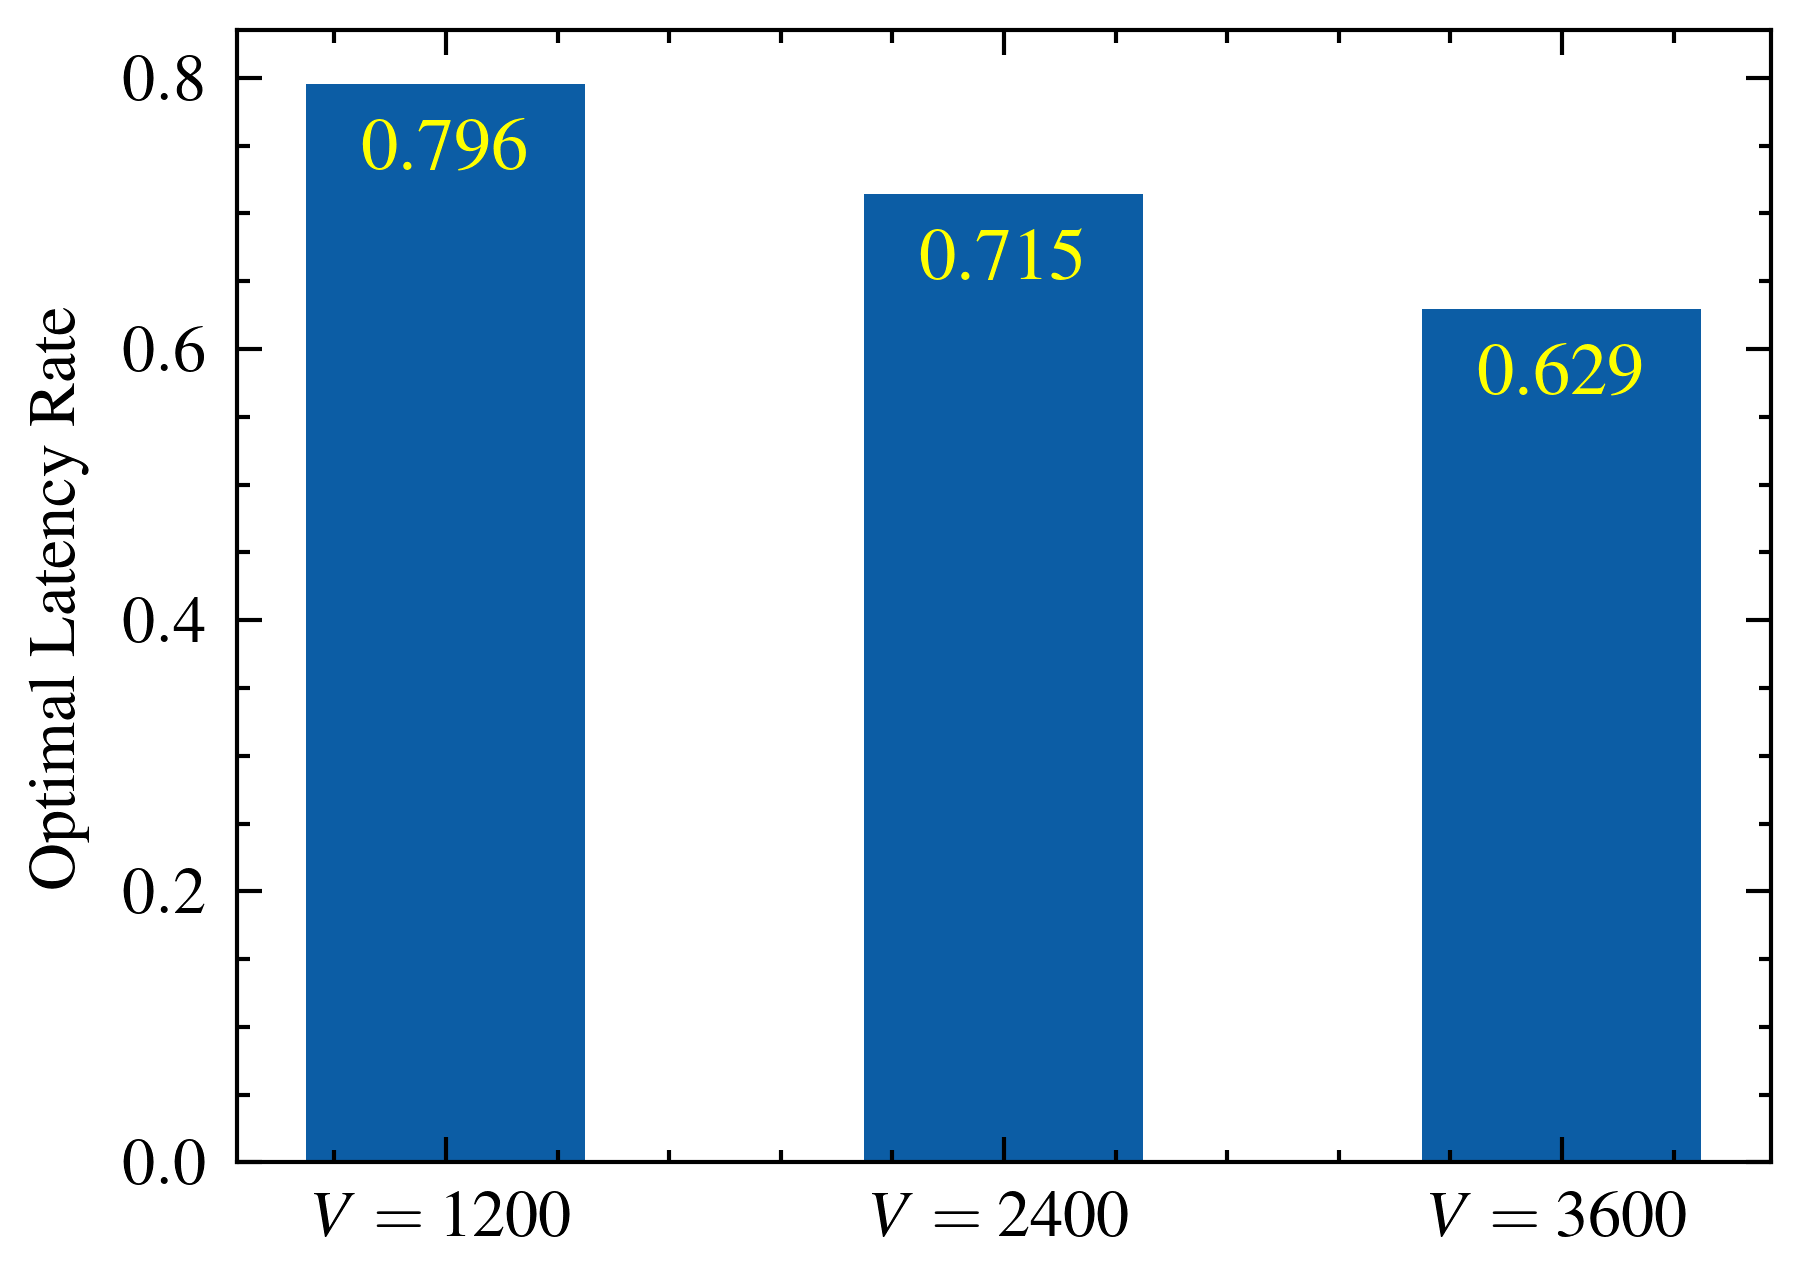

In [9]:
lopt_tiers = [0] * len(test_v)
    
lopt_percent = []
for ti in t_multi2:
    true_tiers = np.count_nonzero(np.array(lopt_tiers)==np.array(ti))
    lopt_percent.append(true_tiers / len(opt_tiers))

plot_h(lopt_percent, [f'$V={Vs2[0]}$', f'$V={Vs2[1]}$', f'$V={Vs2[2]}$'], 'Optimal Latency Rate', './V_optlatencytierrate.pdf')

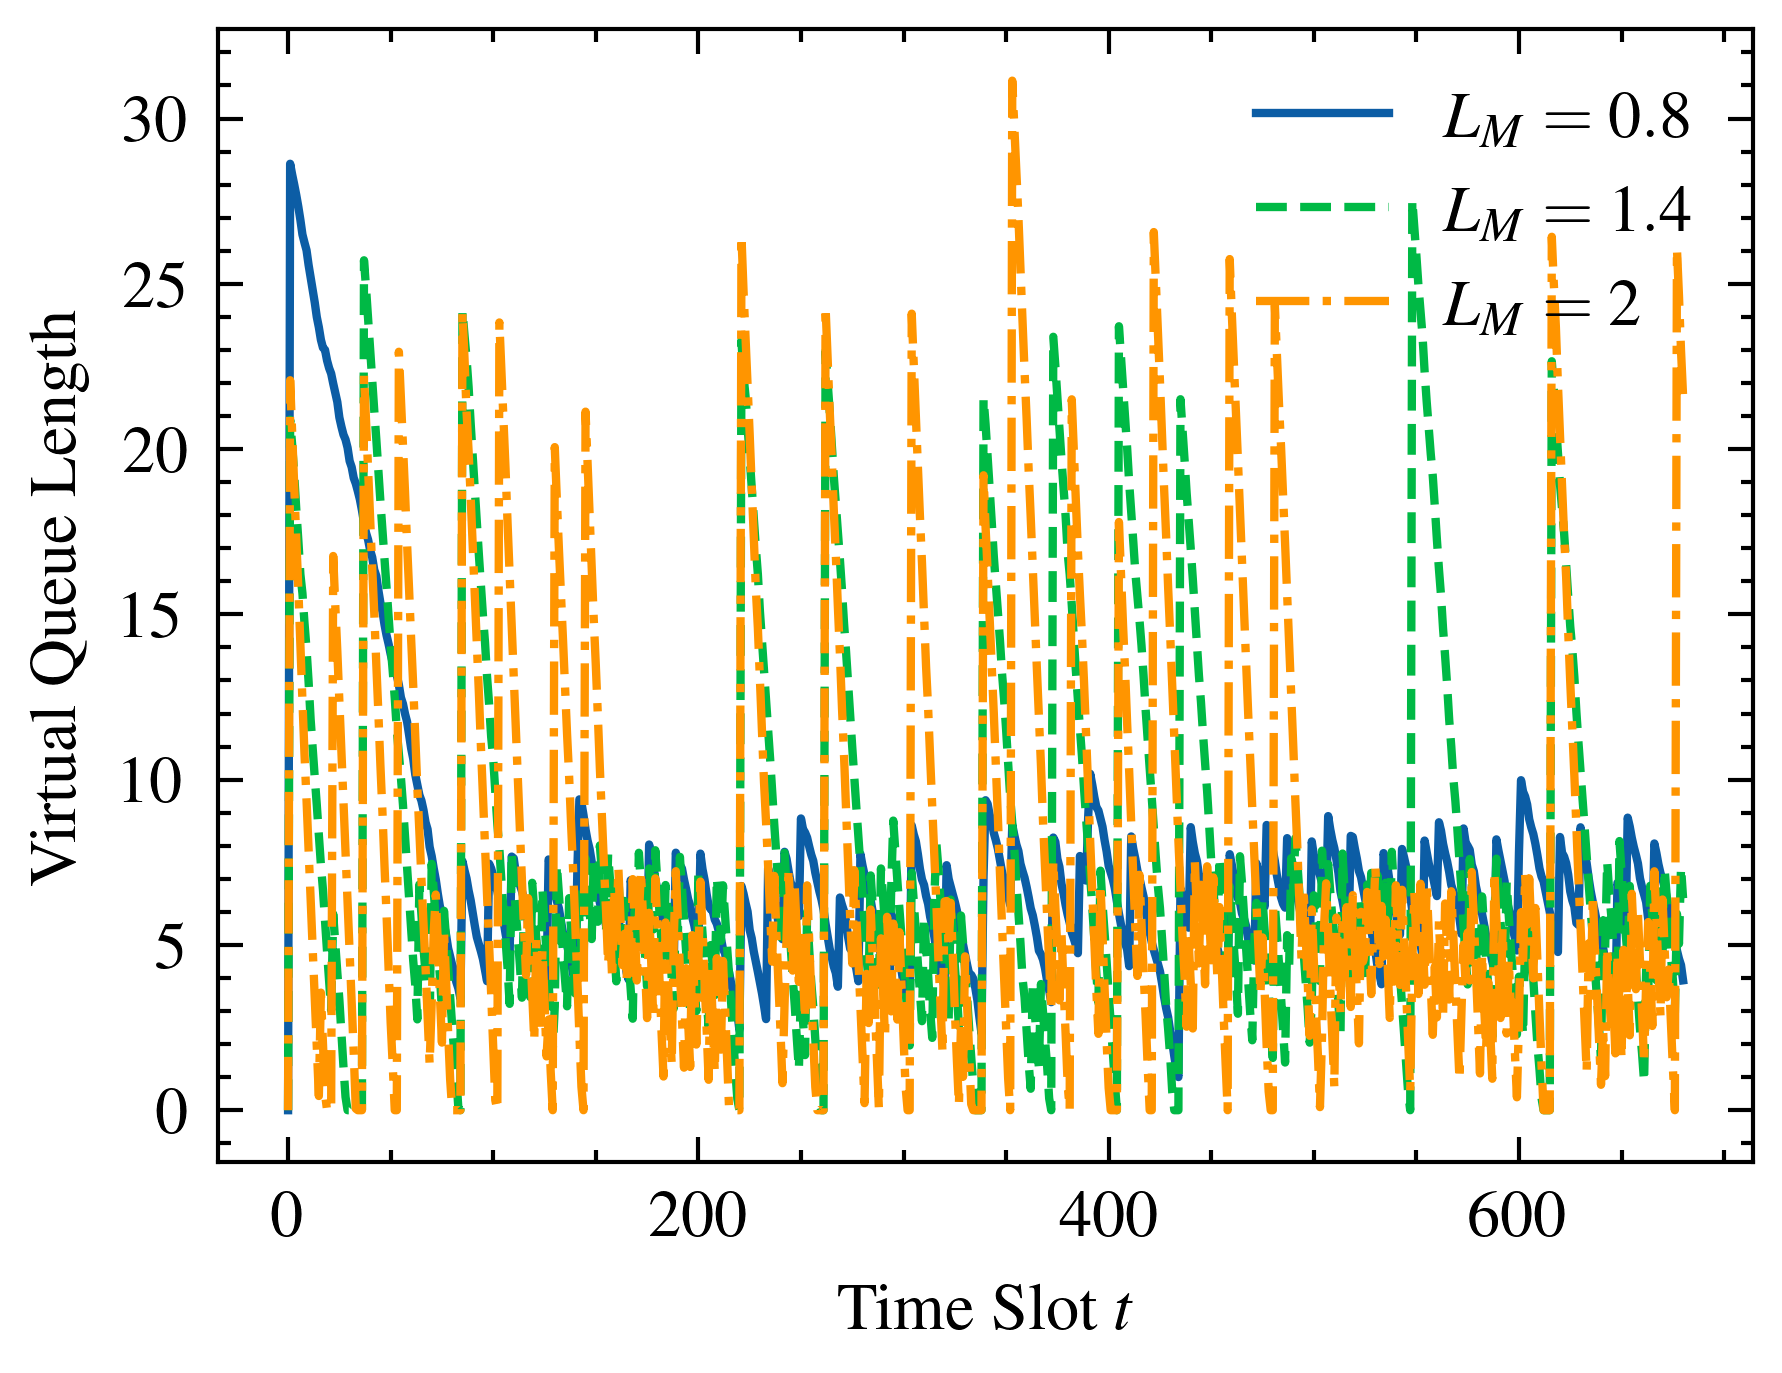

In [78]:
LMs = [0.8, 1.4, 2]
q_multi_LM = []

for i in LMs:
    qs, cs, ls, ts = alg(test_v, test_s, L_M=i, V=1200)
    q_multi_LM.append([np.arange(len(qs)), qs])

    
plot_line(q_multi_LM, [f'$L_M={LMs[0]}$', f'$L_M={LMs[1]}$', f'$L_M={LMs[2]}$'], 'Time Slot $t$', 'Virtual Queue Length', './LM_queuelen.pdf')

In [10]:
LMs2 = [1, 10, 20]
c_multi_LM = []
l_multi_LM = []
t_multi_LM = []
for i in LMs2:
    qs, cs, ls, ts = alg(test_v, test_s, L_M=i)
    c_multi_LM.append(cs)
    l_multi_LM.append(ls)
    t_multi_LM.append(ts)

[1.         0.02039926 0.01178139]
[2408.2636 2404.6716 2404.64  ]
2404.596800000004


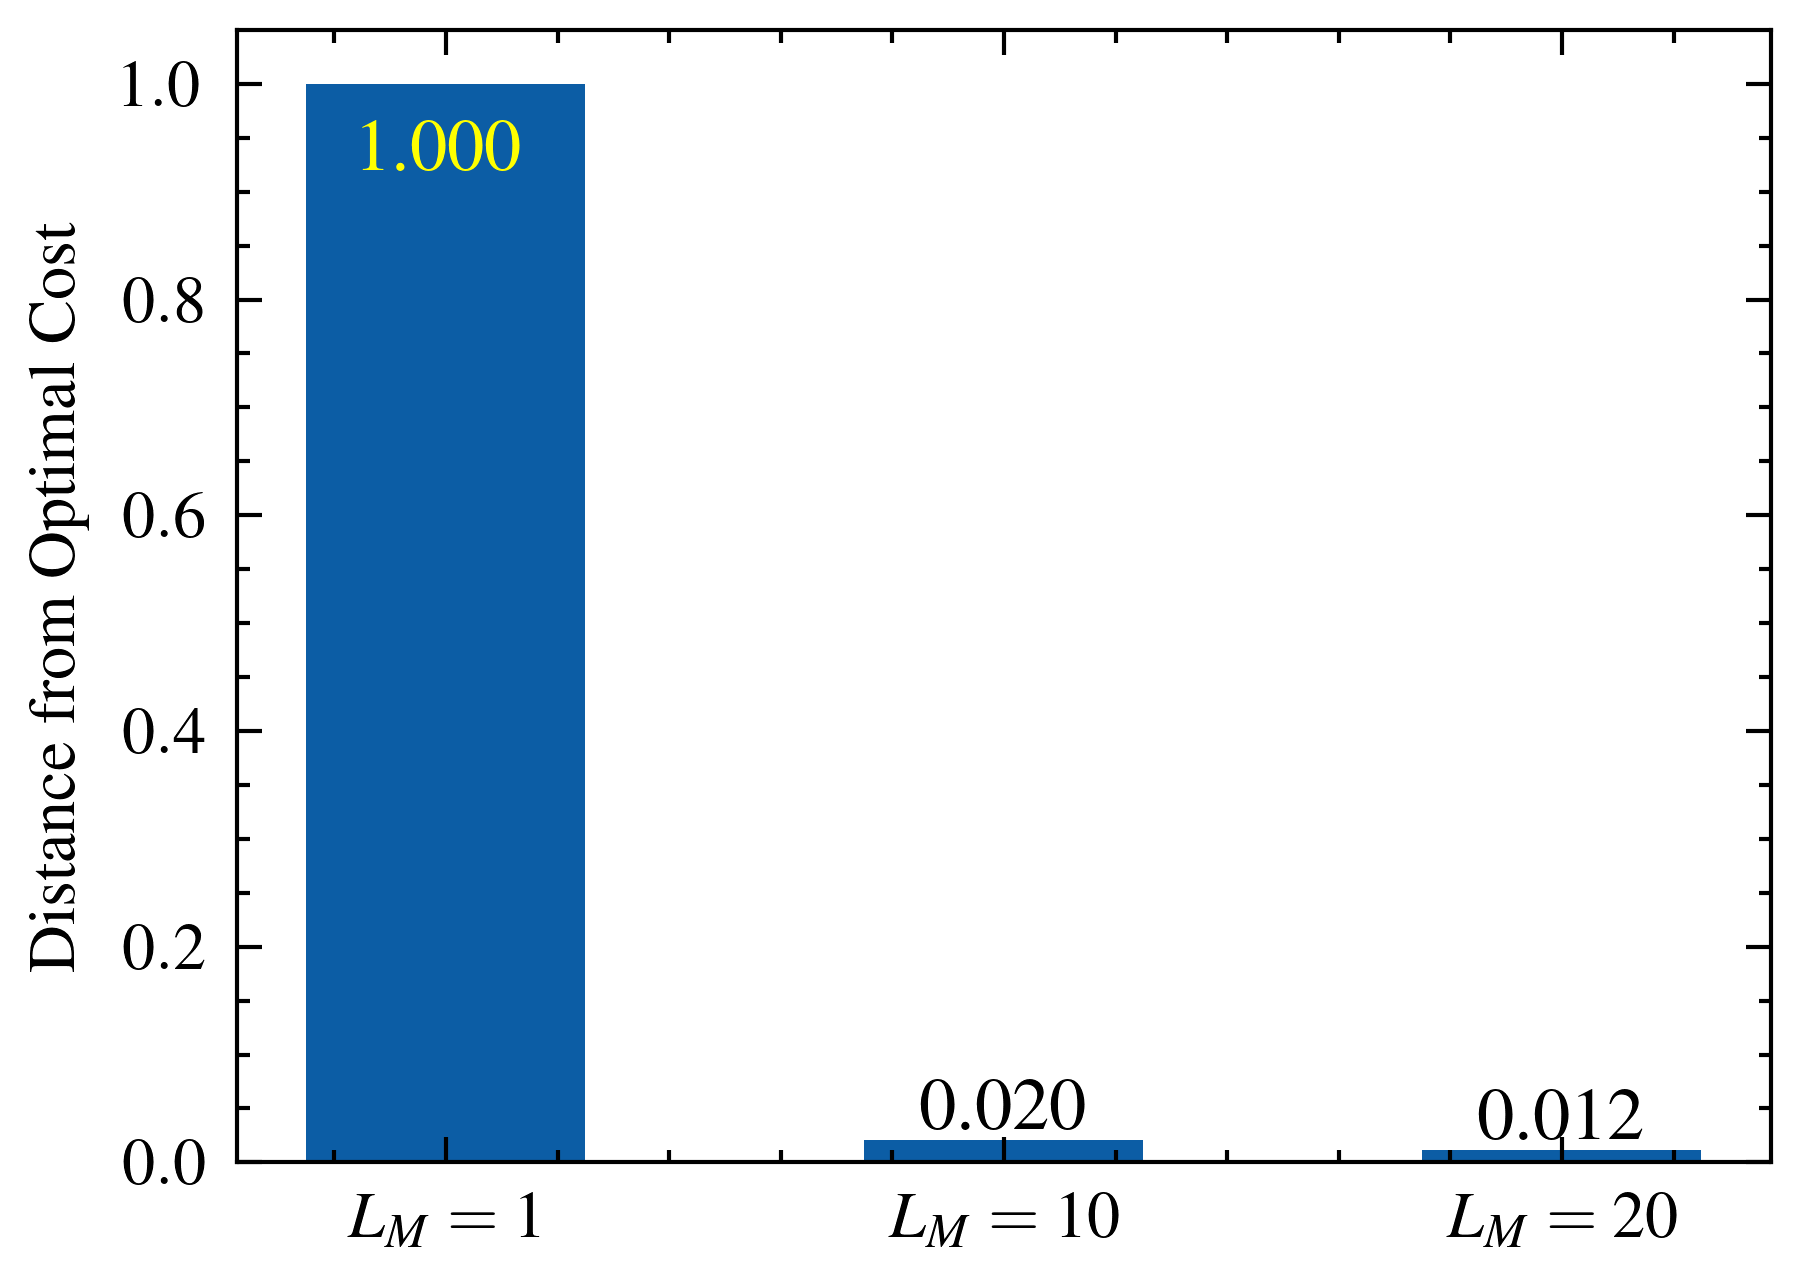

In [11]:
sum_c_LM = np.sum(c_multi_LM, axis=1)
dis_c_LM = sum_c_LM - opt_cost
print(dis_c_LM/dis_c_LM[0])
print(sum_c_LM)
print(opt_cost)
plot_h(dis_c_LM/dis_c_LM[0], [f'$L_M={LMs2[0]}$', f'$L_M={LMs2[1]}$', f'$L_M={LMs2[2]}$'], 'Distance from Optimal Cost', './LM_costdistance.pdf') # 成本离OPT的距离

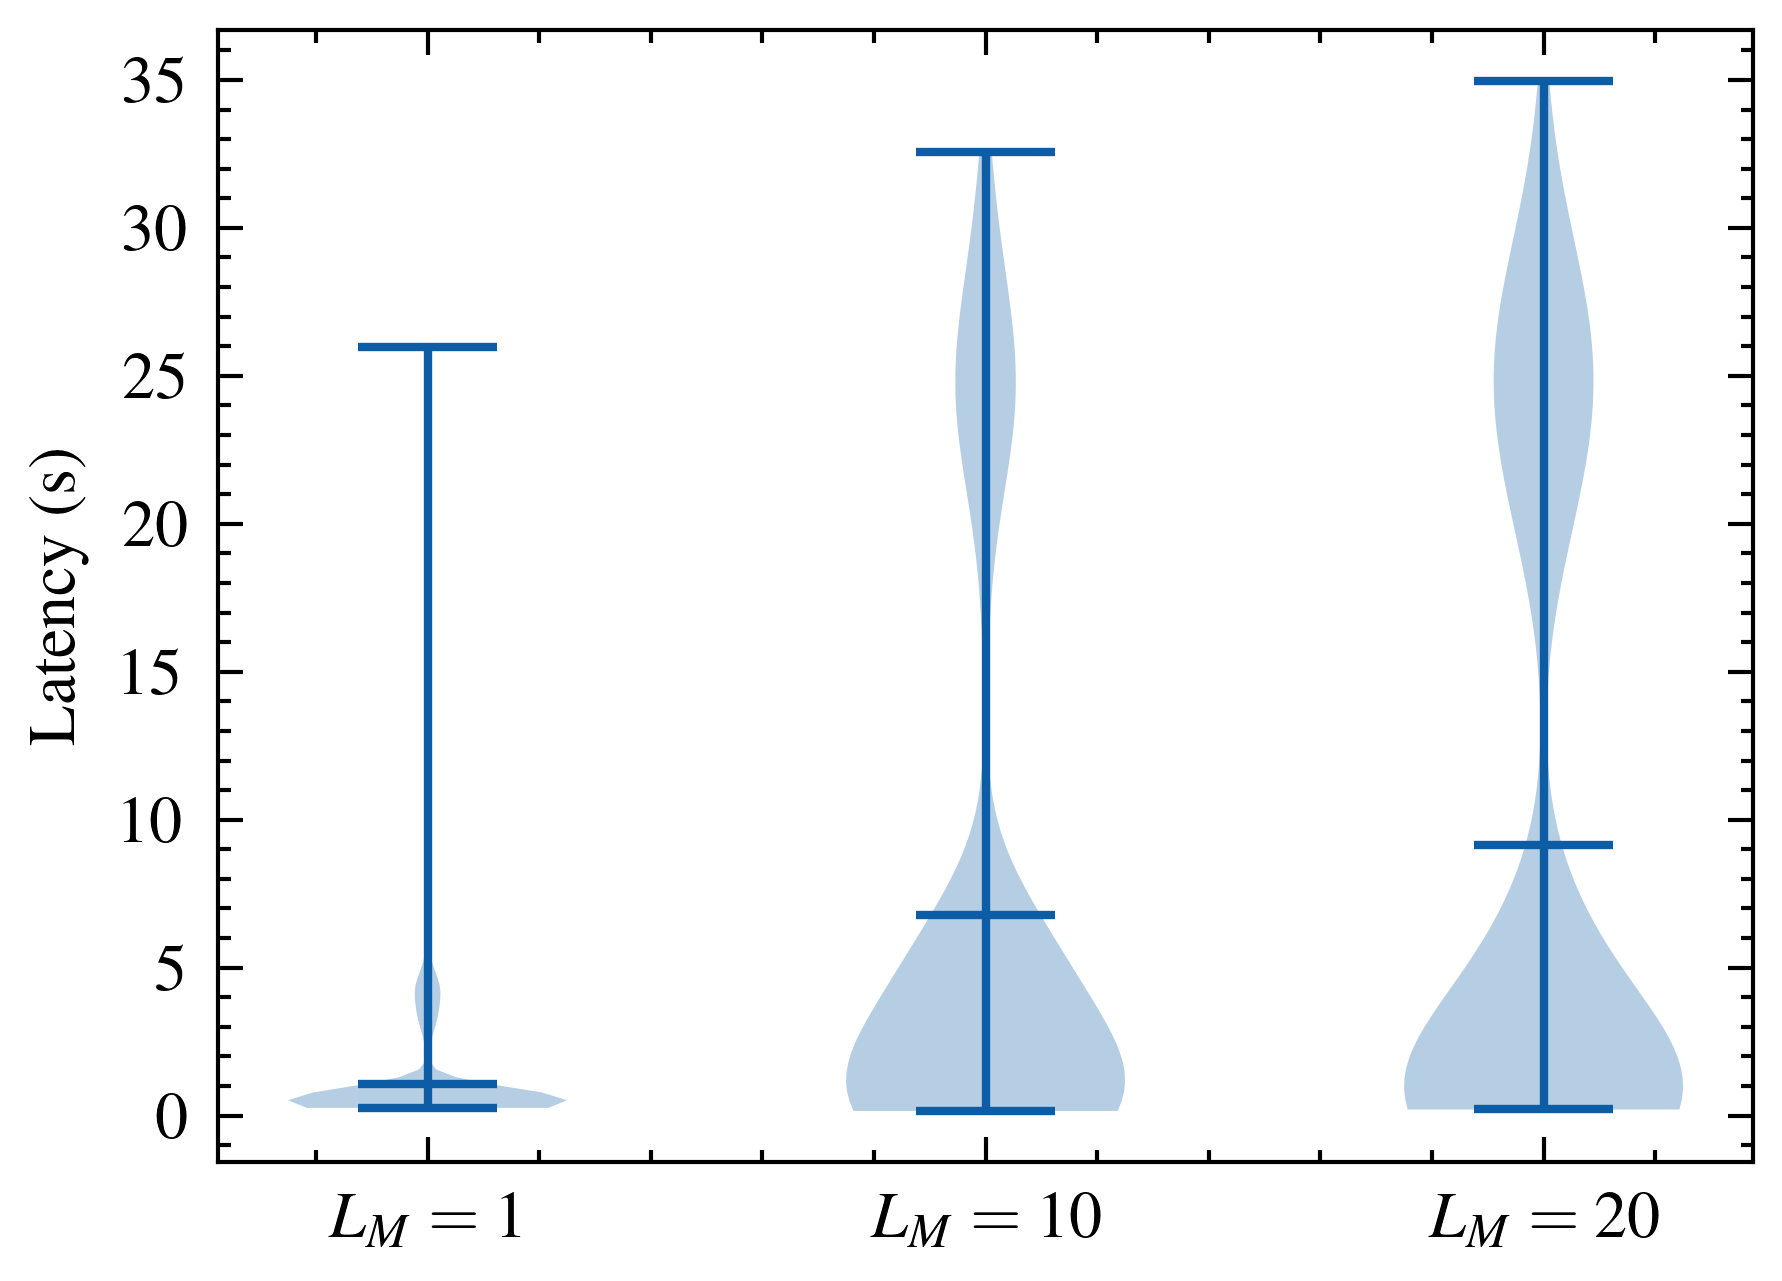

In [12]:
plot_violin(l_multi_LM, [f'$L_M={LMs2[0]}$', f'$L_M={LMs2[1]}$', f'$L_M={LMs2[2]}$'], 'Latency (s)', savepath='./LM_latency.pdf') 

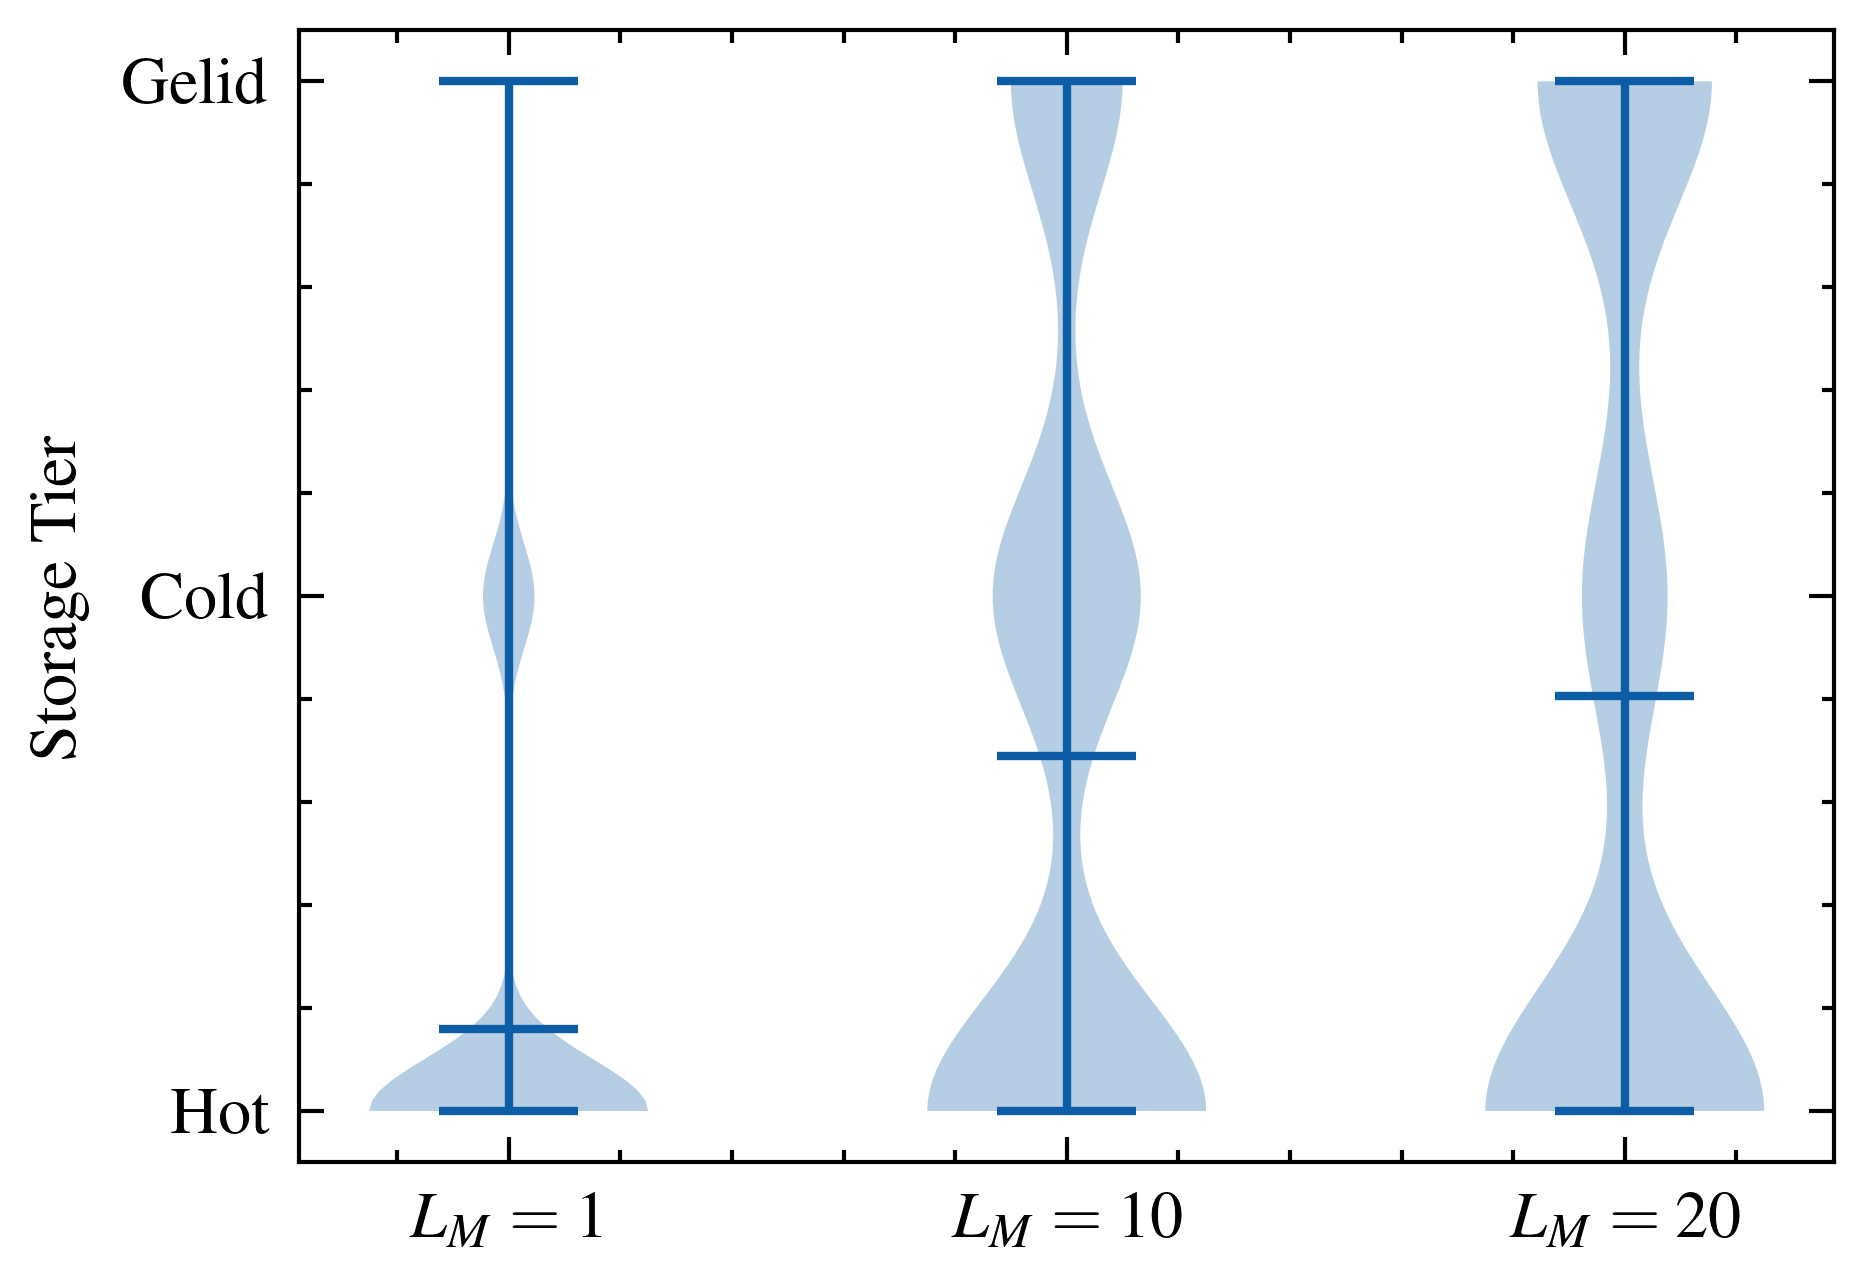

In [13]:
plot_violin(t_multi_LM, [f'$L_M={LMs2[0]}$', f'$L_M={LMs2[1]}$', f'$L_M={LMs2[2]}$'], 'Storage Tier', y_ticklabels=['Hot', 'Cold', 'Gelid'], savepath='./LM_tier.pdf')

#### 不同算法的性能对比
1. 成本比较：本算法、latency-optimal、IEEE Cloud、TNSM
2. 时均队列长度比较：本算法，cost-optimal，IEEE Cloud、TNSM

##### 算法实现

In [16]:
tmp_LM = 1

def l_opt(visits, size):
    # 计算成本
    c = 0
    ls = []
    for v in visits:
        c += cal_cost(0, v, size)
        ls.append(gen_latency(0))
    return c, ls


def c_opt(visits, size):
    # 计算时均队列长度和延迟
    opt_latencies = []
    opt_tiers = []
    q = 0
    opt_qs = [q]
    c = 0
    for v in visits:
        tmp_costs = [cal_cost(0, -1, v, size), cal_cost(1, -1, v, size), cal_cost(2, -1, v, size)]
        tier = np.argmin(tmp_costs)
        c += np.min(tmp_costs)
        tmp_latency = gen_latency(tier)
        q = cal_q(q, tmp_latency, tmp_LM)
        opt_qs.append(q)
        opt_latencies.append(tmp_latency)
        opt_tiers.append(tier)
    return opt_qs, opt_latencies, opt_tiers, c

In [17]:
import math, random

# TNSM 2021

def inverse_discontinuous_cdf(num_read):
    if num_read == 0:
        num_read = 1
    thr_t = threshold_t(num_read)
    rand_prob = random_probability()
    lamb = S_c / S_h
    alph = R_h / R_c
    if int(rand_prob) == 1:
        return (lamb / alph) / (thr_t * (math.e - 1 + lamb / alph))
    else:
        return thr_t * math.log((math.e - 1 + lamb / alph) * rand_prob + 1)

def threshold_t(num_read):
    return (num_read * (R_c - R_h) + R_h) / (S_h - S_c)

def random_probability():
    LARGE_INT = 1000
    r = random.randint(0, LARGE_INT) * 1.0 / LARGE_INT
    return r

            
def rand(visits, size, inverse_cdf=inverse_discontinuous_cdf):
    c = R_h * size * visits[0] + S_h * size
    q = 0
    rand_qs = [q]
    tiers = [0]
    ls = []
    t = 1
    while t < len(visits):
        delta_t = int(round(inverse_cdf(visits[t]), 0))
        c += R_h * size * sum(visits[t:t+delta_t]) + S_h * size * len(visits[t:t+delta_t])
        
        tmp_latency = gen_latency(0)
        q = cal_q(q, tmp_latency, tmp_LM)
        rand_qs.append(q)
        for _ in range(delta_t):
            tmp_latency = gen_latency(0)
            q = cal_q(q, tmp_latency, tmp_LM)
            rand_qs.append(q)
            tiers.append(0)
            ls.append(tmp_latency)

        hot_delta = R_h * sum(visits[t:t+delta_t]) + S_h * delta_t
        cold_delta = R_c * sum(visits[t:t+delta_t]) + R_h + S_c * delta_t

        t += delta_t

        if hot_delta >= cold_delta:
            c += R_h * size 
            c += R_c * size * sum(visits[t:]) + S_c * size * len(visits[t:])
            for _ in range(t, len(visits)):
                tmp_latency = gen_latency(1)
                q = cal_q(q, tmp_latency, tmp_LM)
                rand_qs.append(q)
                tiers.append(1)
                ls.append(tmp_latency)
            break
    return c, rand_qs, tiers, ls


# CLOUD 2018
def NR(visits, size):
    delta_t = round((R_h + R_c) / (S_h - S_c))
    t_len = len(visits)
    t = 0
    c = 0
    q = 0
    nr_qs = [q]
    tiers = []
    ls = [] 
    flag = 0 
    while t < t_len:
        if t + delta_t > t_len:
            delta_t = t_len - t
        
        if visits[t] > 0:
            c += R_h * size * sum(visits[t:t+delta_t]) + S_h * size * delta_t 
            for _ in range(delta_t):
                tmp_latency = gen_latency(0)
                q = cal_q(q, tmp_latency, tmp_LM)
                nr_qs.append(q)
                tiers.append(0)
                ls.append(tmp_latency)
            if flag == 1:
                c += R_c * size
                flag = 0
            t += delta_t
        else:
            c += S_c * size
            tmp_latency = gen_latency(1)
            q = cal_q(q, tmp_latency, tmp_LM)
            nr_qs.append(q)
            tiers.append(1)
            ls.append(tmp_latency)
            if flag == 0:
                c += R_h * size
                flag = 1
            t += 1
    return c, nr_qs, tiers, ls

##### 算法执行

In [25]:
a_qs, a_cs, a_ls, a_tiers = alg(test_v, test_s, L_M=2, V=3600)
l_csum, l_ls = l_opt(test_v, test_s)
c_opt_qs, c_opt_ls, c_opt_tiers, c_opt_costsum = c_opt(test_v, test_s)
nr_csum, nr_qs, nr_tiers, nr_ls = NR(test_v, test_s)
rand_csum, rand_qs, rand_tiers, rand_ls =  rand(test_v, test_s)
a_csum = sum(a_cs)

##### 存储层比较

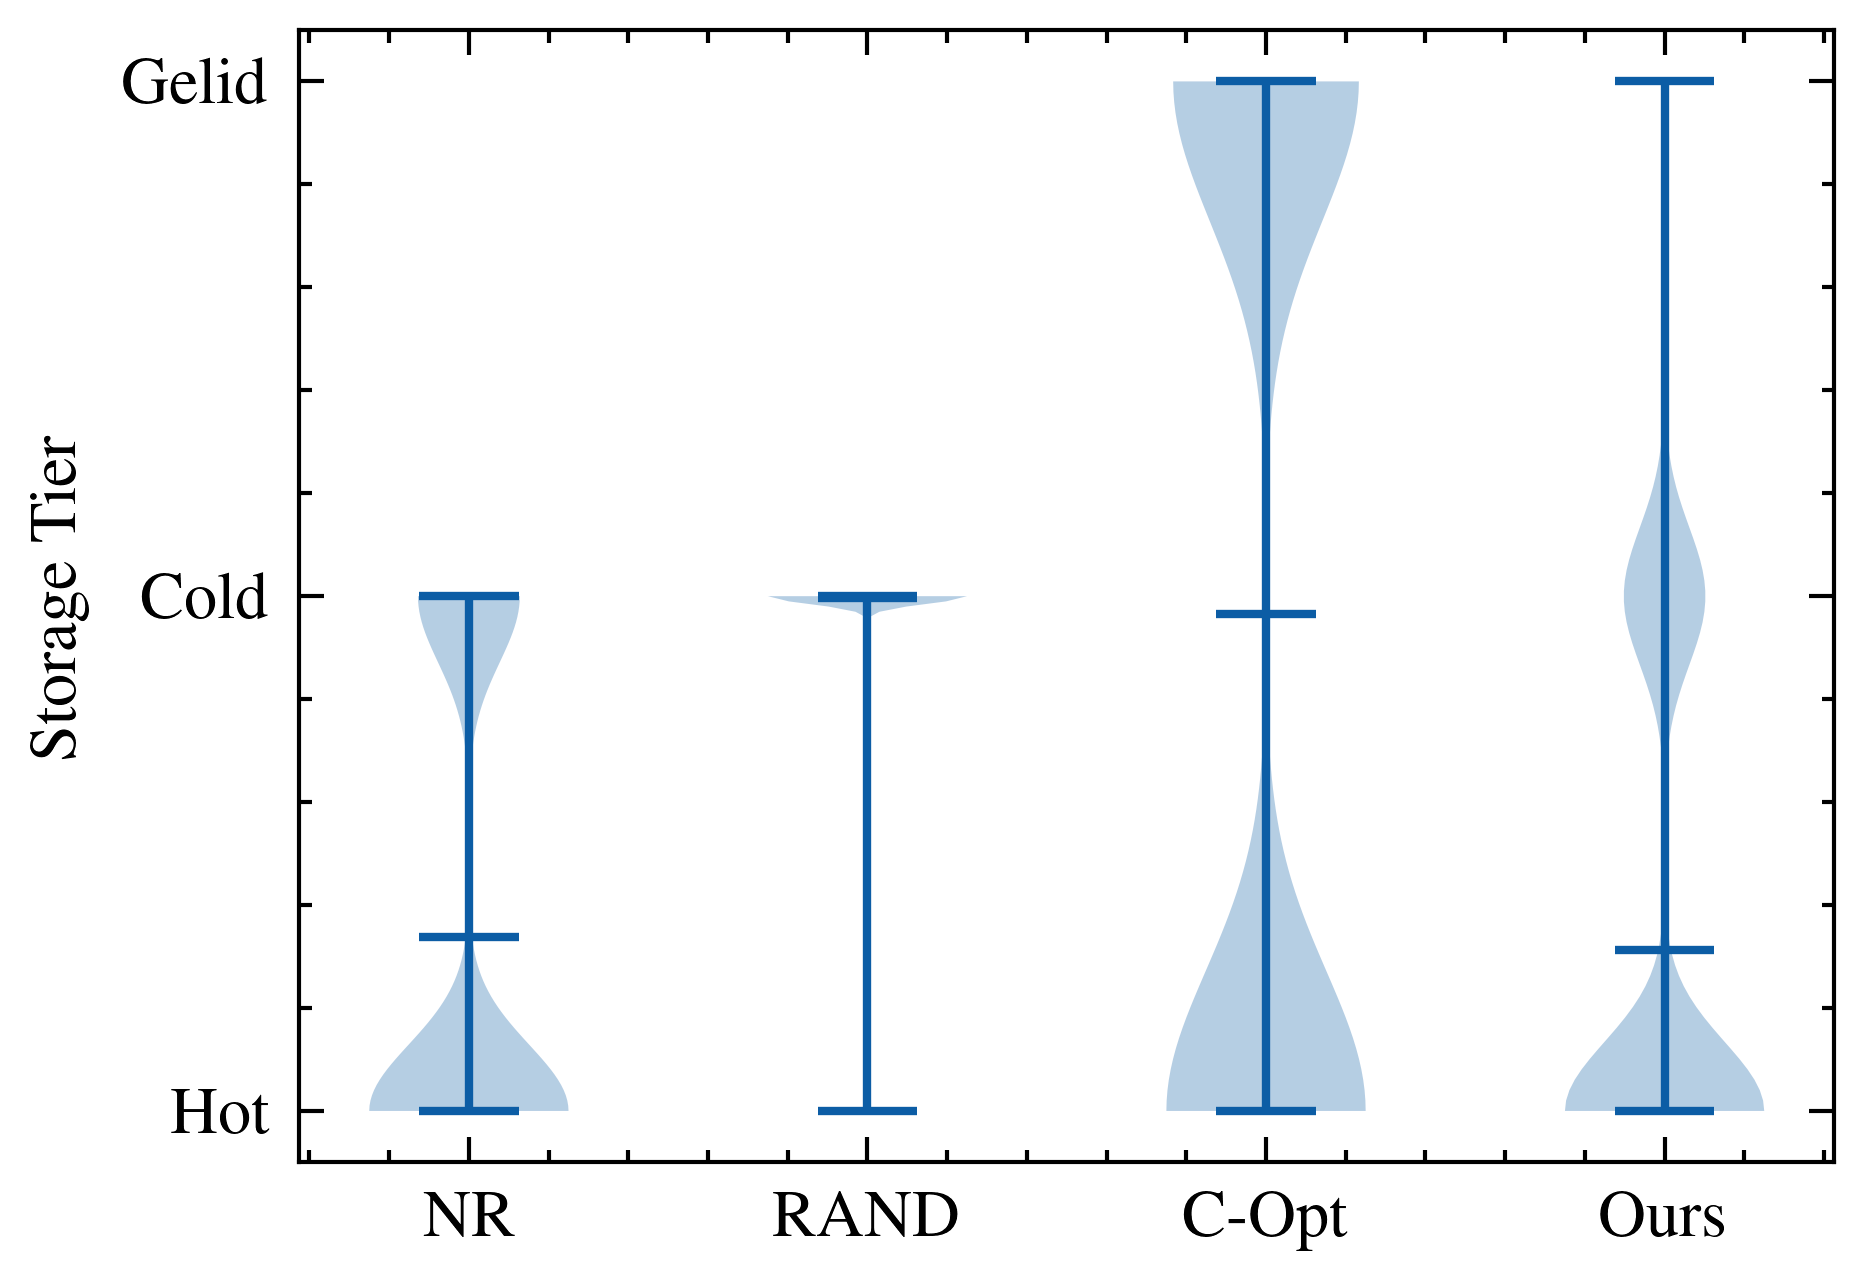

In [19]:
all_tiers = [nr_tiers, rand_tiers, c_opt_tiers, a_tiers]

plot_violin(all_tiers, ['NR', 'RAND', 'C-Opt', 'Ours'], 'Storage Tier', y_ticklabels=['Hot', 'Cold', 'Gelid'], savepath='./comp_tier.pdf') 

##### 时均成本比较

与最优成本的距离的log

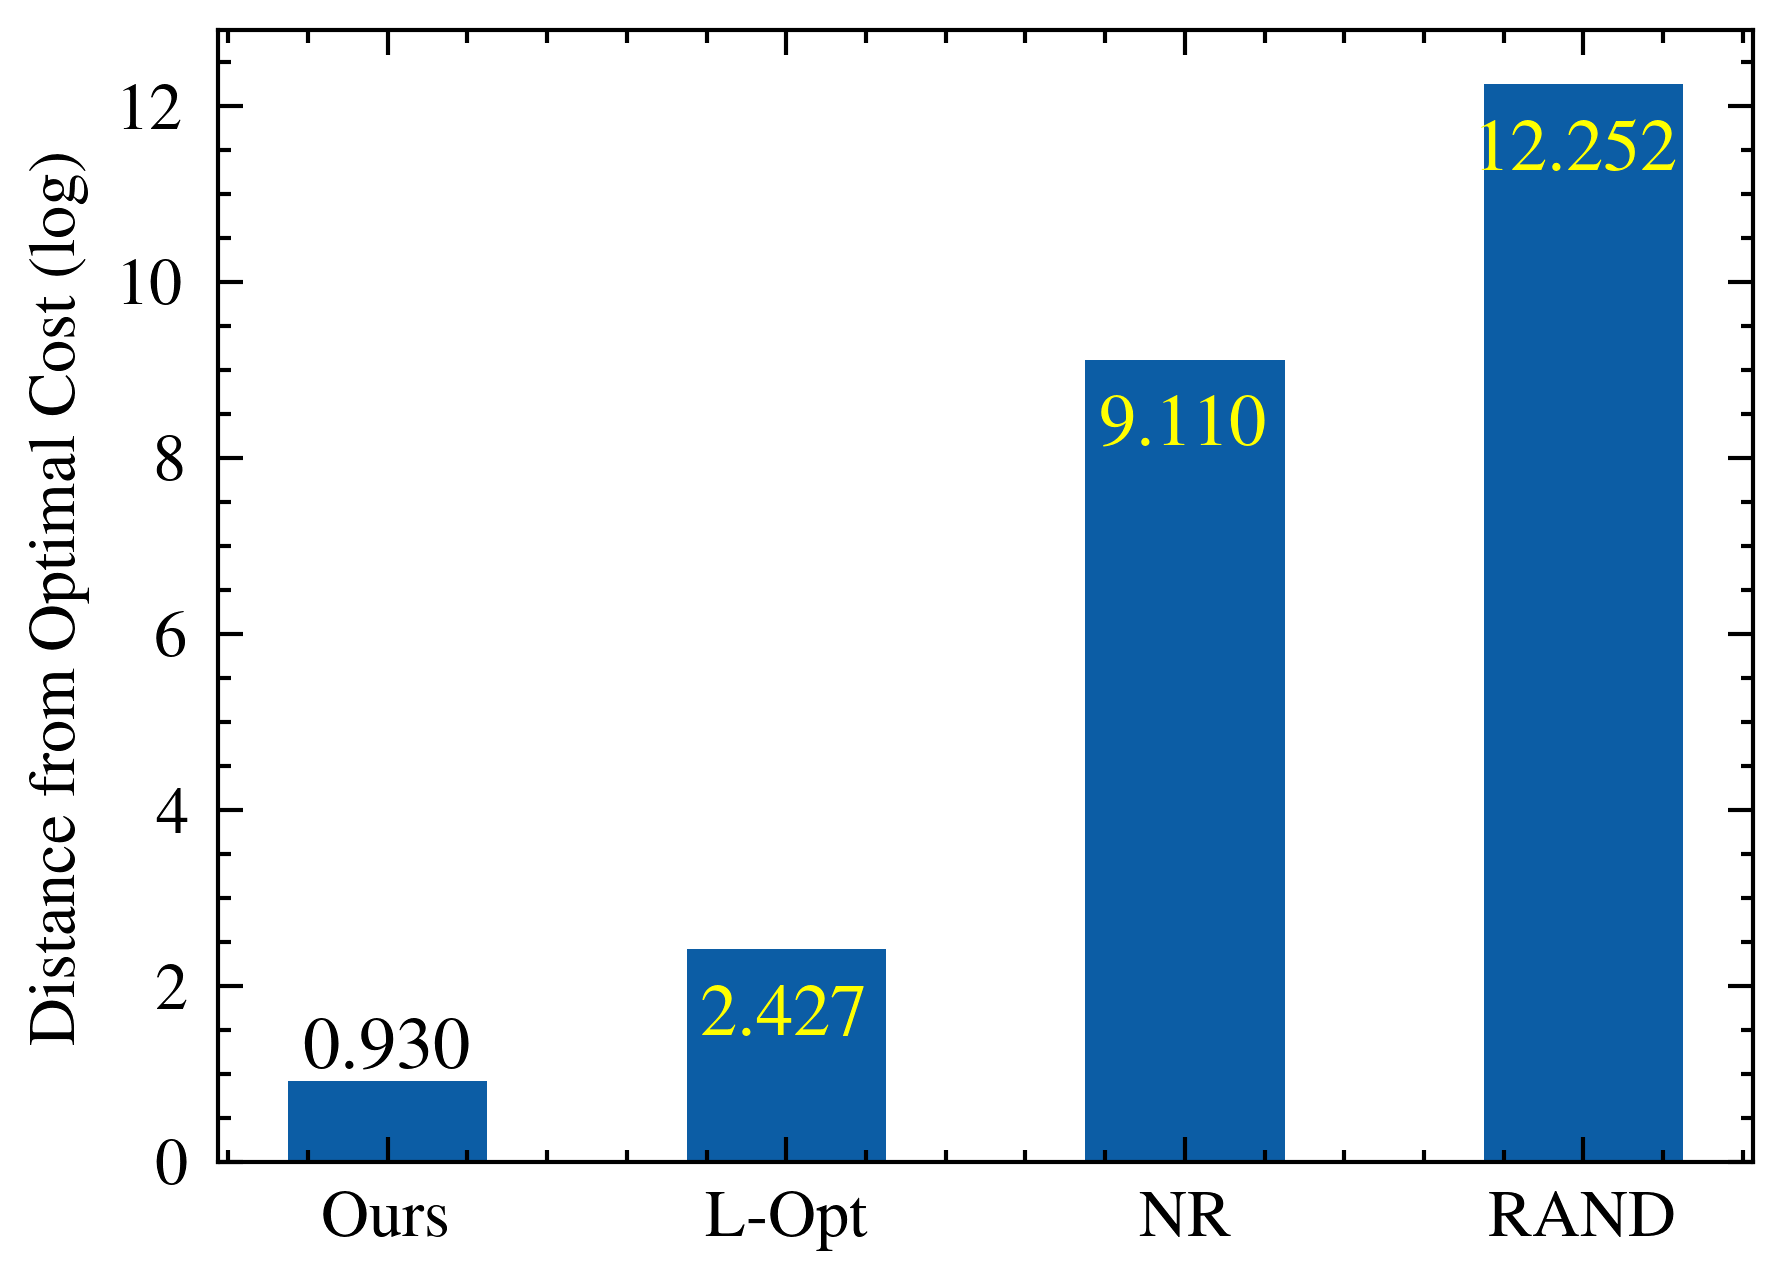

In [22]:
a_c_dis = a_csum - c_opt_costsum
l_c_dis = (l_csum - c_opt_costsum) 
nr_c_dis = (nr_csum - c_opt_costsum) 
rand_c_dis = (rand_csum - c_opt_costsum) 
plot_h(np.log2([a_c_dis , l_c_dis, nr_c_dis, rand_c_dis]), ['Ours', 'L-Opt', 'NR', 'RAND'], 'Distance from Optimal Cost (log)', './comp_costdislog.pdf')

##### 时均延迟比较

In [31]:
def plot_h_latency(data, xtick_labels, y_label=None, savepath=None):      
    x = xtick_labels
    y = data
    
    plt.figure()
    bar_width = 0.5
    plt.bar(x, y, width=bar_width)
    
    fig_width = 5
    plt.plot(np.arange(0-bar_width, fig_width-bar_width, 1), [0.499] * fig_width, color='g', label='Optimal Latency')
    plt.plot(np.arange(0-bar_width, fig_width-bar_width, 1), [2] * fig_width, color='r', label='$L_M=2$', linestyle='-.')
    for a,b,i in zip(x, y,range(len(x))): 
        text_y = b-max(y)*0.08
        precision = "%.3f"
        if text_y > 10:
            precision = "%.2f" 
        if text_y <= max(y)*0.005:
            text_y = b+max(y)*0.01
            plt.text(a, text_y, precision%y[i], ha='center', fontsize=9) 
        else:
            plt.text(a, text_y, precision%y[i], ha='center', fontsize=9, color='white') 
    plt.ylabel(y_label)
    plt.legend()
    plt.ticklabel_format(style='sci',scilimits=(-2,2),axis='y') 
    if savepath:
        plt.savefig(savepath, bbox_inches = 'tight', dpi=300)

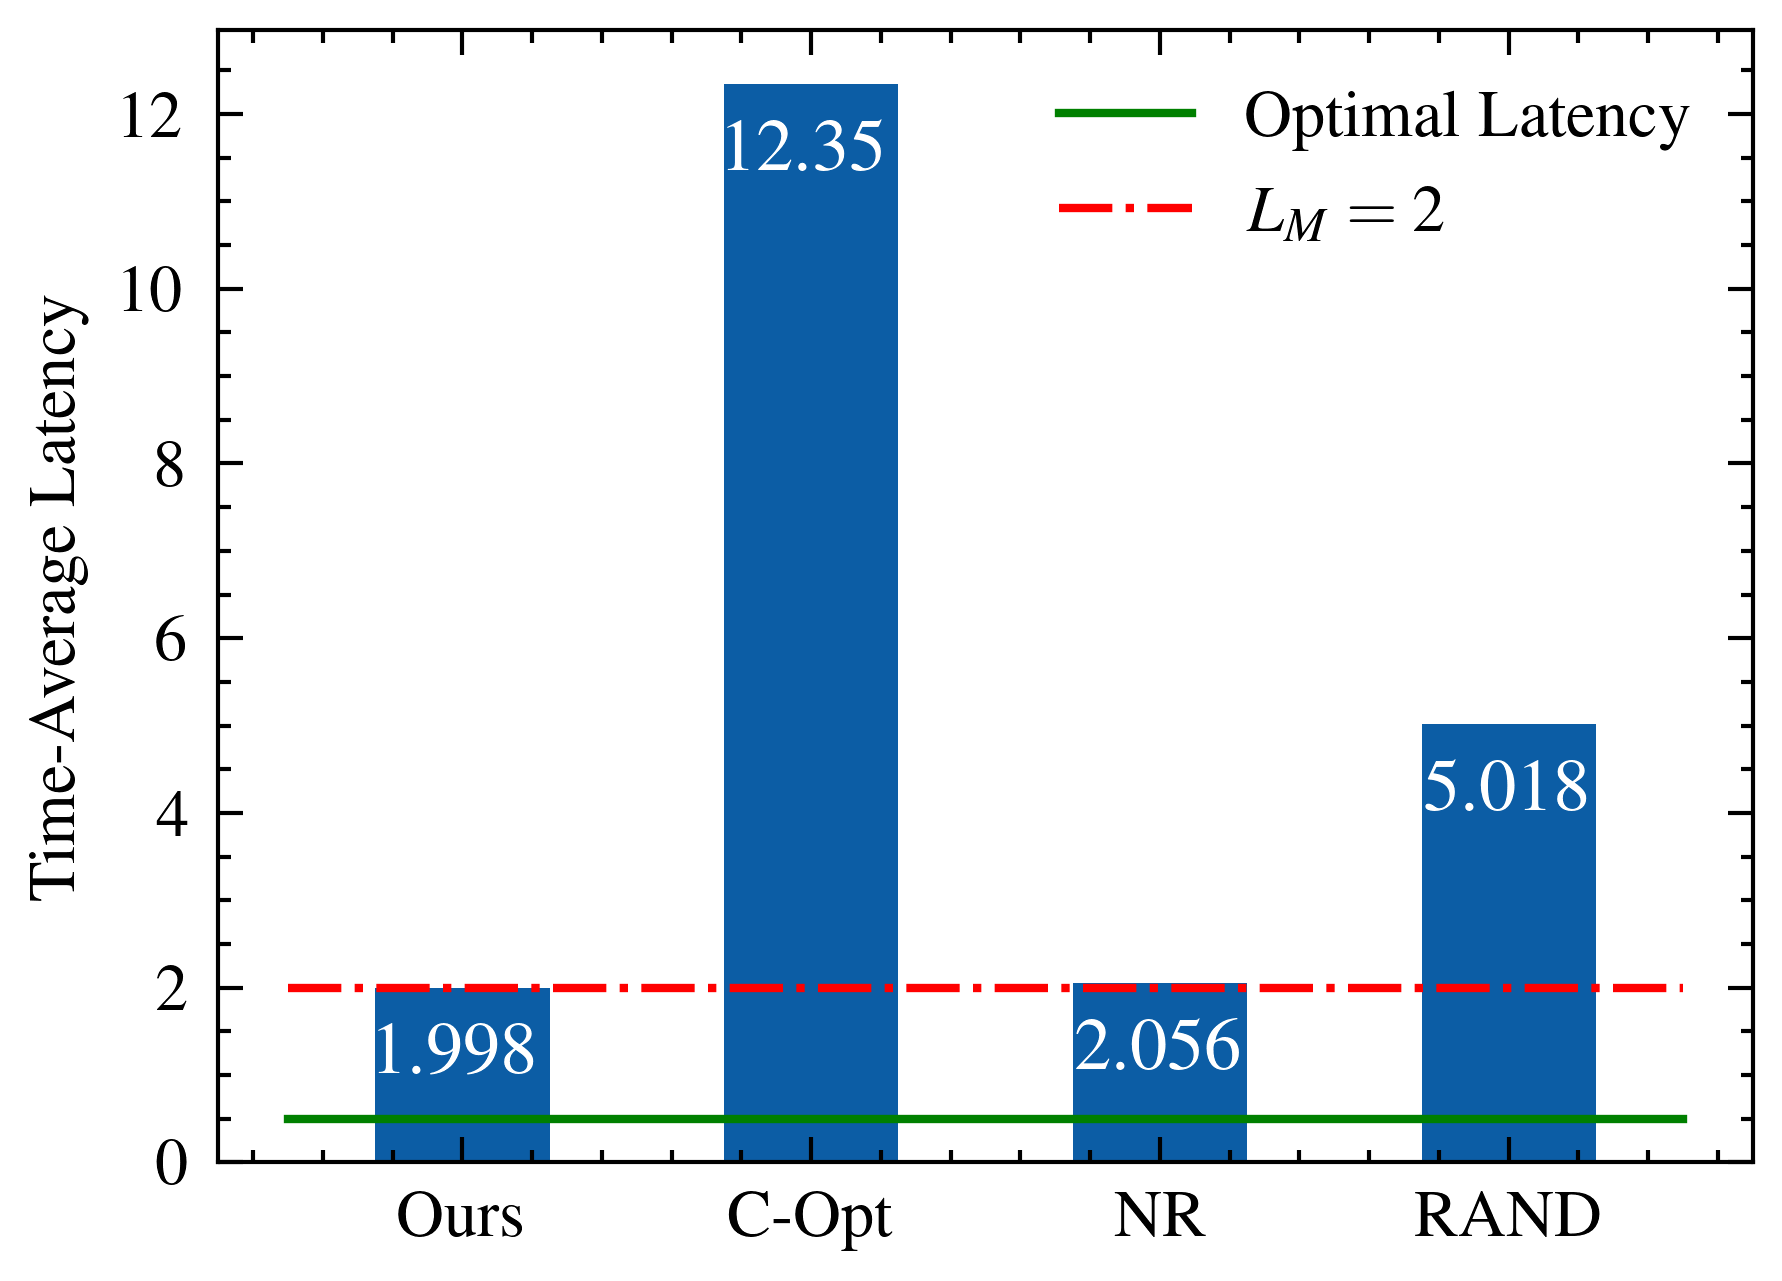

In [32]:
l_l_timeavg = sum(l_ls) / len(l_ls)
a_l_timeavg = sum(a_ls) / len(a_ls)
c_opt_l_timeavg = sum(c_opt_ls) / len(c_opt_ls) 
nr_l_timeavg = sum(nr_ls) / len(nr_ls) 
rand_l_timeavg = sum(rand_ls) / len(rand_ls) 
plot_h_latency([a_l_timeavg, c_opt_l_timeavg, nr_l_timeavg, rand_l_timeavg], ['Ours', 'C-Opt', 'NR', 'RAND'], 'Time-Average Latency', './comp_latency.pdf')

##### 队列长度比较

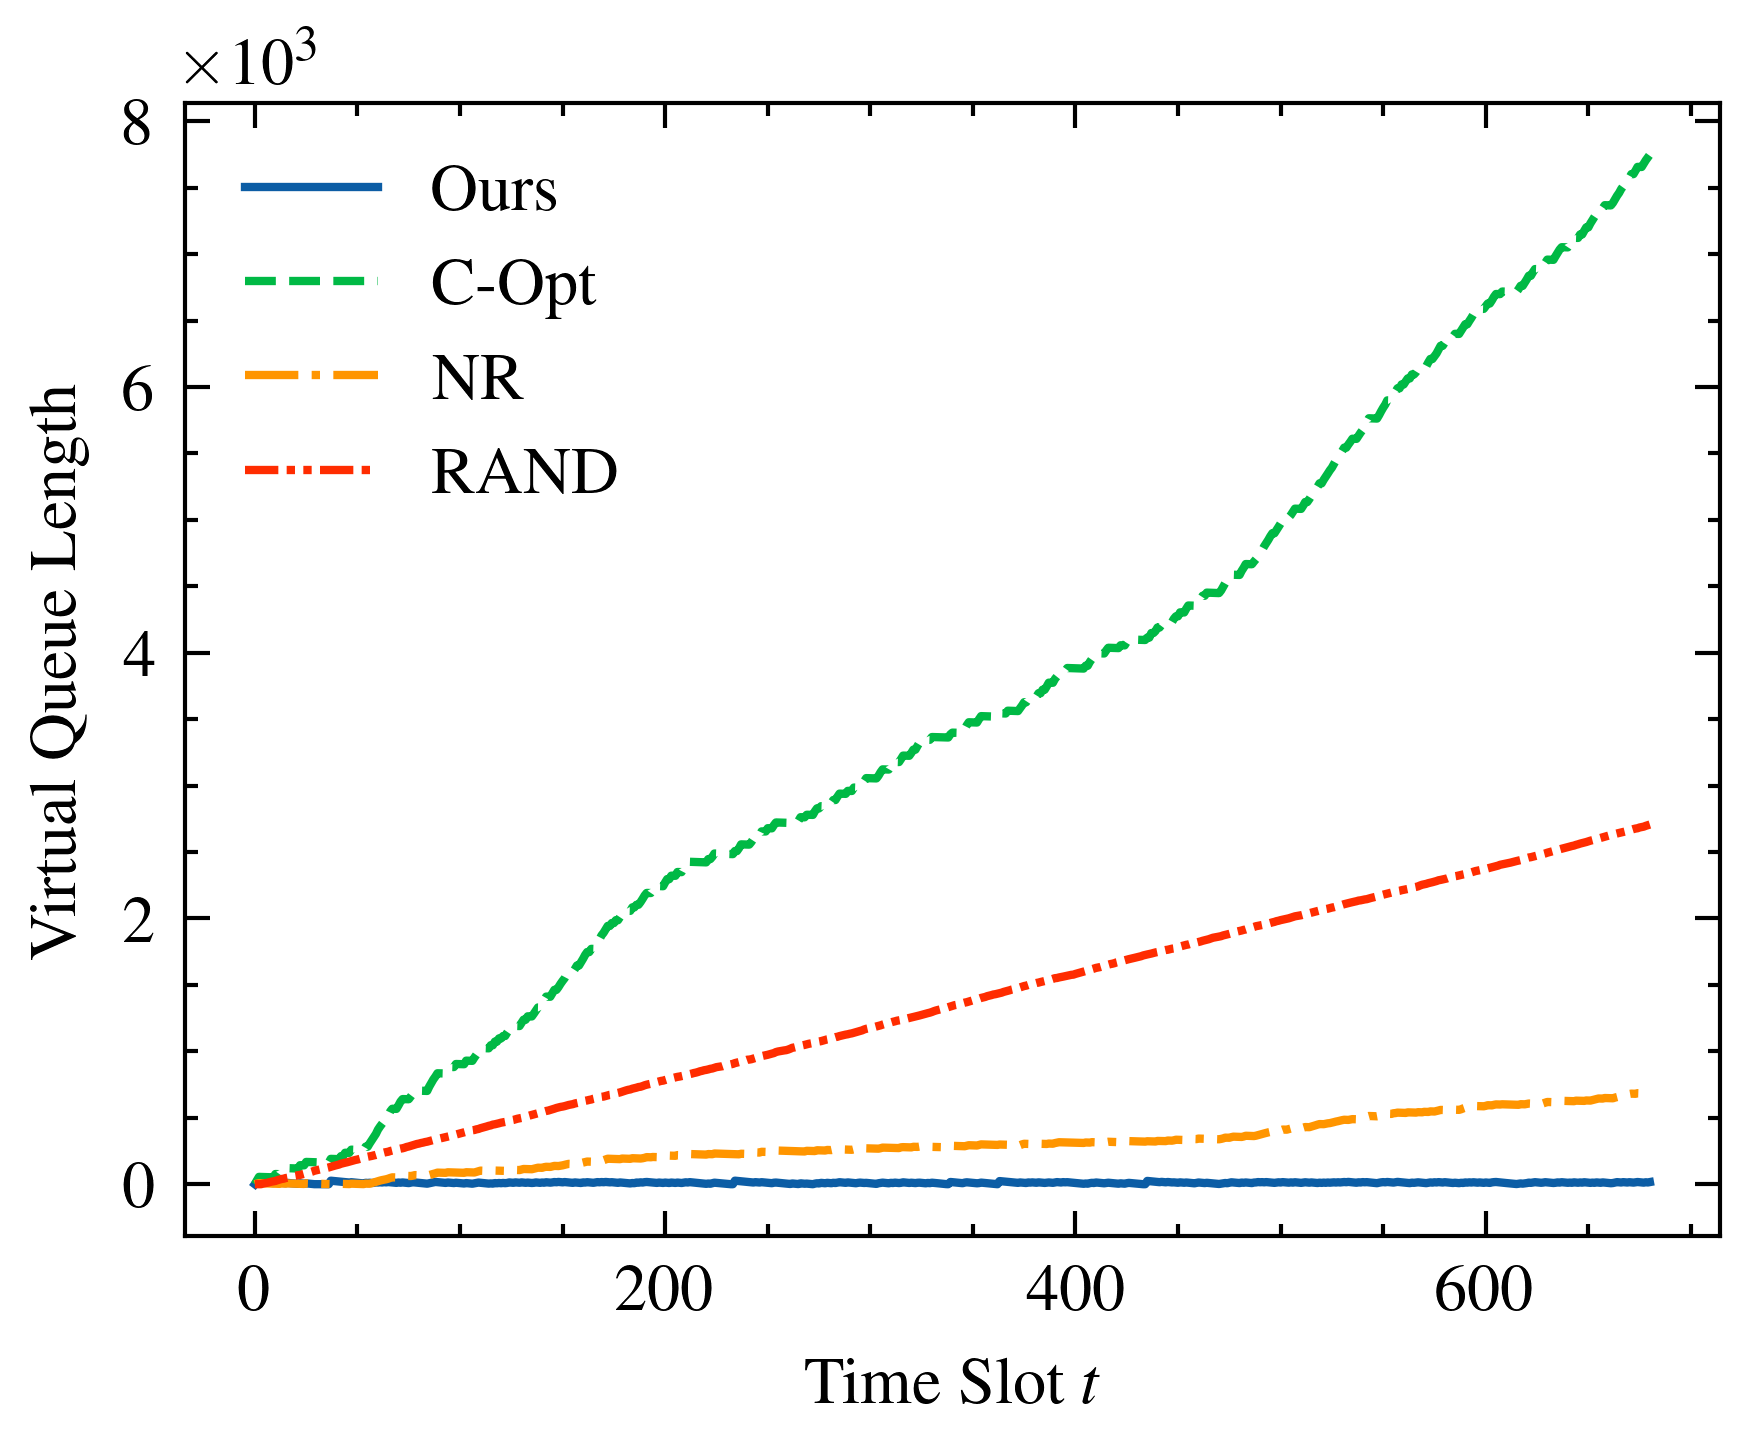

In [161]:
qss = [a_qs, c_opt_qs, nr_qs, rand_qs]
qs_xy = []

for tmp_qs in qss:
    qs_xy.append([list(range(len(tmp_qs))), tmp_qs])

plot_line(qs_xy, ['Ours', 'C-Opt', 'NR', 'RAND'], 'Time Slot $t$', 'Virtual Queue Length', './comp_queue.pdf')

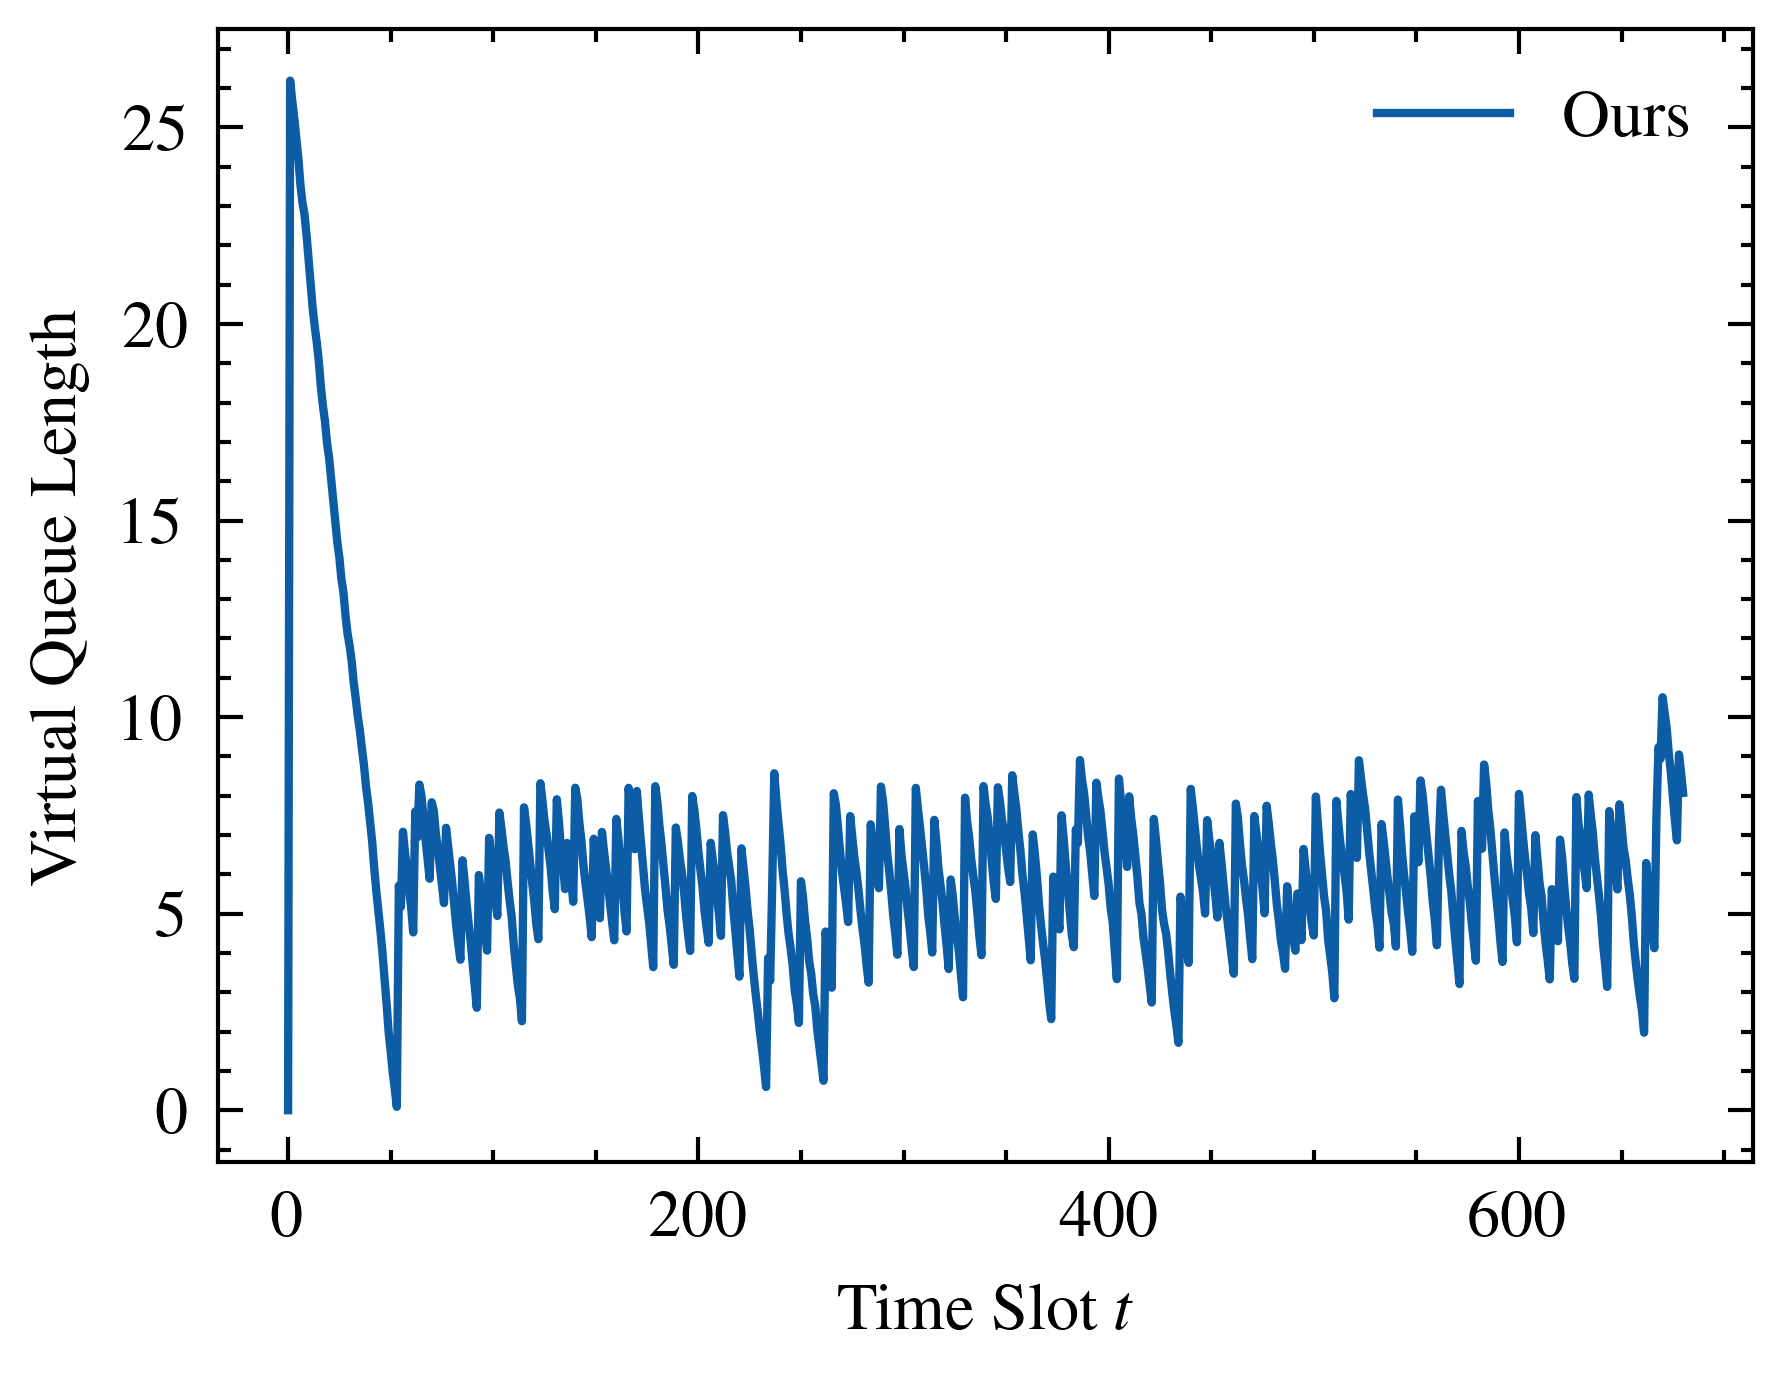

In [118]:
plot_line(qs_xy[:1], ['Ours'], 'Time Slot $t$', 'Virtual Queue Length', './comp_queue_alg.pdf')